In [1]:
import torch
from torch import nn
import numpy as np
import tqdm
import pytorch_lightning
import matplotlib.pyplot as plt

from torch.distributions import Normal

from case_studies.dc2_mdt.utils.new_simulate_image import ImageSimulator

In [2]:
image_size = 4
max_objects = 1
image_normalize_strategy = "linear_scale"

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, layers, hidden_ch):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(image_size * image_size * max_objects, hidden_ch),
            nn.LayerNorm(hidden_ch),
            nn.ReLU(),
            *[
                nn.Sequential(
                    nn.Linear(hidden_ch, hidden_ch),
                    nn.LayerNorm(hidden_ch),
                    nn.ReLU(),
                ) for _ in range(layers)
            ],
            nn.Linear(hidden_ch, 2)
        )
    
    def forward(self, image):
        x = image.flatten(start_dim=1)
        return self.network(x).chunk(2, dim=-1)
    
    def nll(self, image, true_fluxes):
        loc, scale = self(image)
        # scale = torch.ones_like(scale) * 0.05
        return -1 * Normal(loc, scale.abs() + 1e-5).log_prob(true_fluxes)
    
    def sample(self, image, sample_size):
        loc, scale = self(image)
        # scale = torch.ones_like(scale) * 0.05
        return Normal(loc, scale.abs() + 1e-5).sample(sample_size)

In [4]:
device = torch.device("cuda:5")
batch_size = 1024
val_batch_size = 1000  # 30_000
training_iters = 5000
val_iters = 5000
log_freq = 500
seed = 1201023
pytorch_lightning.seed_everything(seed)

Seed set to 1201023


1201023

In [5]:
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 max_objects=max_objects,
                                 psf_stdev=1.0 if image_size > 1 else 0.1,
                                 flux_alpha=10.0,
                                 flux_beta=0.01).to(device=device)

In [6]:
my_net = SimpleMLP(layers=8, hidden_ch=256).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-4, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 4 * 3], gamma=0.1)

In [7]:
# def encode_flux(flux: torch.Tensor):
#     assert flux.min() >= 0.0
#     return torch.log1p(flux)

# def decode_flux(log_flux: torch.Tensor):
#     return torch.expm1(log_flux)

In [8]:
max_flux_boundary = 2000.0
def encode_flux(flux: torch.Tensor):
    assert flux.min() >= 0.0
    return flux / max_flux_boundary

def decode_flux(flux: torch.Tensor):
    return flux * max_flux_boundary

In [9]:
# def encode_flux(flux: torch.Tensor):
#     assert flux.min() >= 0.0
#     return flux

# def decode_flux(log_flux: torch.Tensor):
#     return log_flux

In [10]:
my_net.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    target_fluxes = catalog["fluxes"][:, 0:1]  # (b, 1)
    input_image = catalog["images"]  # (b, m, h, w)
    match image_normalize_strategy:
        case "none":
            pass
        case "log":
            input_image = torch.log1p(input_image)
        case "linear_scale":
            input_image = input_image / 1000
        case _:
            raise NotImplementedError()
    loss = my_net.nll(input_image, encode_flux(target_fluxes)).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

 10%|█         | 509/5000 [00:08<01:10, 63.29it/s]

[500/5000] loss: 7.152e-01


 20%|██        | 1013/5000 [00:16<01:02, 64.12it/s]

[1000/5000] loss: 3.172e-01


 30%|███       | 1510/5000 [00:24<00:53, 64.76it/s]

[1500/5000] loss: -8.136e-01


 40%|████      | 2007/5000 [00:31<00:45, 65.56it/s]

[2000/5000] loss: 9.202e-01


 50%|█████     | 2511/5000 [00:39<00:38, 64.99it/s]

[2500/5000] loss: 1.589e+00


 60%|██████    | 3008/5000 [00:46<00:30, 64.90it/s]

[3000/5000] loss: 1.255e+00


 70%|███████   | 3507/5000 [00:54<00:22, 65.46it/s]

[3500/5000] loss: -6.180e-01


 80%|████████  | 4008/5000 [01:02<00:15, 66.05it/s]

[4000/5000] loss: -1.579e+00


 90%|█████████ | 4512/5000 [01:09<00:07, 65.29it/s]

[4500/5000] loss: -2.507e+00


100%|██████████| 5000/5000 [01:17<00:00, 64.74it/s]

[5000/5000] loss: -2.571e+00


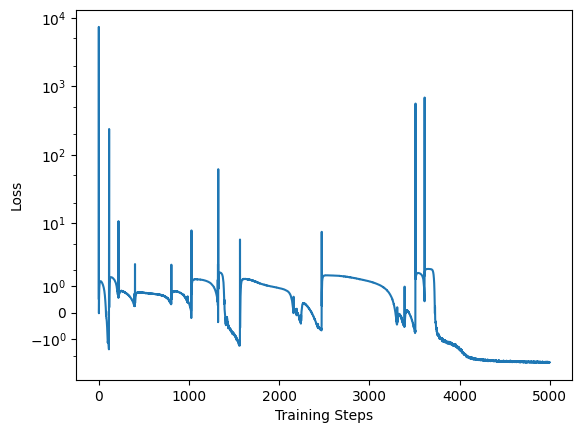

In [11]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("asinh")
plt.show()

In [12]:
my_net.eval()
val_true_fluxes = None
val_est_fluxes = []
with torch.inference_mode():
    val_catalog = image_simulator.generate(batch_size=val_batch_size, 
                                           seed=seed)
    target_fluxes = val_catalog["fluxes"][:, 0:1]  # (b, 1)
    val_true_fluxes = target_fluxes
    input_image = val_catalog["images"]
    match image_normalize_strategy:
        case "none":
            pass
        case "log":
            input_image = torch.log1p(input_image)
        case "linear_scale":
            input_image = input_image / 1000
        case _:
            raise NotImplementedError()
    sample = my_net.sample(input_image, sample_size=[val_iters]).squeeze(0)
    val_est_fluxes = decode_flux(sample).cpu()

In [13]:
val_true_fluxes = val_true_fluxes.cpu()

In [14]:
val_true_fluxes.shape

torch.Size([1000, 1])

In [15]:
val_est_fluxes.shape

torch.Size([5000, 1000, 1])

In [16]:
torch.mean((val_true_fluxes - val_est_fluxes) ** 2)

tensor(3788.6072)

In [17]:
torch.mean(torch.abs(val_true_fluxes - val_est_fluxes))

tensor(45.0294)

In [18]:
val_true_fluxes[:10, 0]

tensor([ 641.4783,  662.8781,  926.4026,  899.5436,  909.7417, 1357.9894,
         880.8101,  998.1847, 1038.0592, 1417.7609])

In [19]:
val_est_fluxes[0, :10, 0]

tensor([ 669.7230,  631.7501, 1062.9158,  902.1962,  875.0392, 1368.6367,
         915.3567, 1085.5558, 1040.6718, 1345.9980])

In [20]:
# plt.hist(val_est_fluxes.flatten(), color="red", alpha=0.5, density=True)
# plt.hist(val_true_fluxes.flatten(), color="green", alpha=0.5, density=True)
# plt.show()

In [21]:
ci_cover = torch.tensor([i / 100 for i in range(5, 100, 5)])
left_q_points = [(1.0 - c) / 2 for c in ci_cover]
right_q_points = [1.0 - lq for lq in left_q_points]
actual_ci_cover = []
for q in zip(left_q_points, right_q_points):
    q = torch.tensor(q)
    est_fluxes_q = val_est_fluxes.quantile(q=q, dim=0).permute([1, 2, 0])  # (b, 1, 2)
    above_lower_bound = val_true_fluxes[:, 0] > est_fluxes_q[:, 0, 0]
    below_upper_bound = val_true_fluxes[:, 0] < est_fluxes_q[:, 0, 1]
    actual_ci_cover.append((above_lower_bound & below_upper_bound).sum() / val_true_fluxes.shape[0])
actual_ci_cover = torch.stack(actual_ci_cover, dim=0)

In [22]:
actual_ci_cover.shape

torch.Size([19])

In [23]:
actual_ci_cover

tensor([0.0490, 0.0970, 0.1490, 0.1990, 0.2400, 0.2830, 0.3310, 0.3820, 0.4360,
        0.4840, 0.5360, 0.5940, 0.6530, 0.6990, 0.7470, 0.7940, 0.8360, 0.8860,
        0.9470])

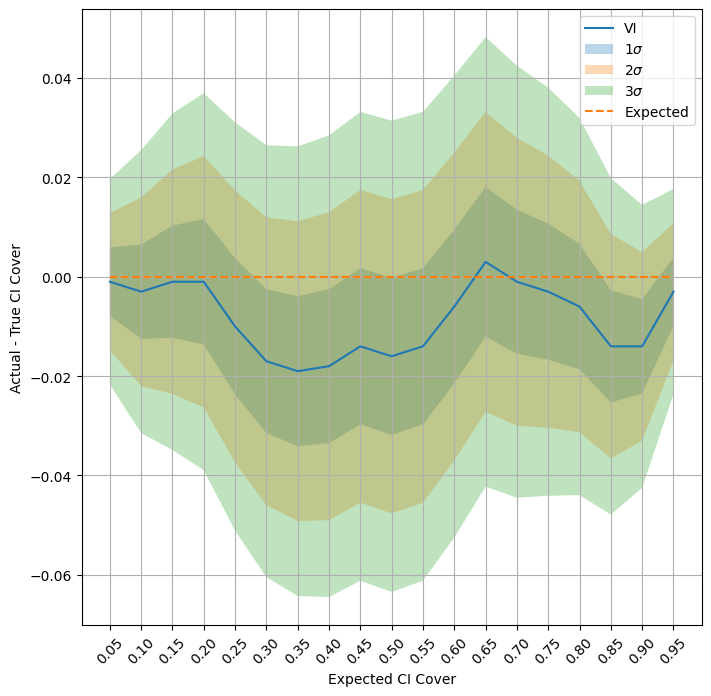

In [24]:
plt.figure(figsize=(8, 8))
a_m_c = actual_ci_cover - ci_cover
ci_sigma = (ci_cover * (1 - ci_cover) / val_batch_size) ** 0.5
plt.plot(ci_cover, a_m_c, label="VI")
plt.fill_between(ci_cover, a_m_c - ci_sigma, a_m_c + ci_sigma, alpha=0.3, label=r"$1\sigma$")
plt.fill_between(ci_cover, a_m_c - 2 * ci_sigma, a_m_c + 2 * ci_sigma, alpha=0.3, label=r"$2\sigma$")
plt.fill_between(ci_cover, a_m_c - 3 * ci_sigma, a_m_c + 3 * ci_sigma, alpha=0.3, label=r"$3\sigma$")
plt.plot(ci_cover, torch.zeros_like(ci_cover), linestyle="dashed", label="Expected")
plt.legend(loc="upper right")
plt.grid()
plt.xticks(ci_cover, rotation=45)
plt.xlabel("Expected CI Cover")
plt.ylabel("Actual - True CI Cover")
plt.show()

In [25]:
q = torch.tensor([0.05, 0.95])
est_fluxes_q = val_est_fluxes.quantile(q=q, dim=0).permute([1, 2, 0])  # (b, 1, 2)

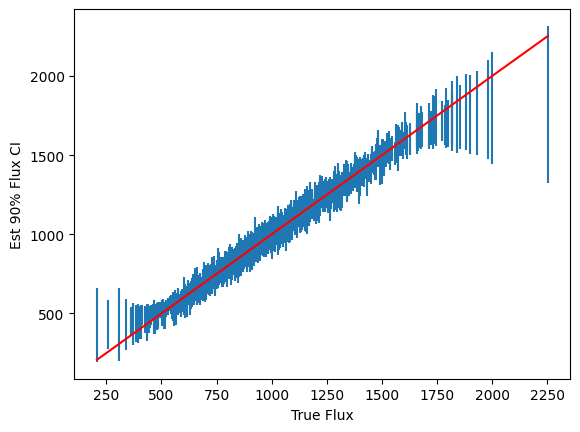

In [26]:
est_fluxes_mean = est_fluxes_q.mean(dim=-1).squeeze(-1)
plt.errorbar(x=val_true_fluxes.flatten(), 
             y=est_fluxes_mean,
             yerr=torch.stack([(est_fluxes_q[:, 0, 0] - est_fluxes_mean).abs(),
                               (est_fluxes_q[:, 0, 1] - est_fluxes_mean).abs()], dim=0),
            fmt="none")
plt.plot([val_true_fluxes.min(), val_true_fluxes.max()], 
         [val_true_fluxes.min(), val_true_fluxes.max()], 
         linestyle="solid", color="red")
plt.xlabel("True Flux")
plt.ylabel("Est 90% Flux CI")
plt.show()

In [27]:
true_post_dist = image_simulator.post_dist(val_catalog)

In [28]:
true_post_dist

MixtureSameFamily(
  Categorical(probs: torch.Size([1000, 1]), logits: torch.Size([1000, 1])),
  Gamma(concentration: torch.Size([1000, 1]), rate: torch.Size([1000, 1])))

In [29]:
val_est_fluxes.shape, val_true_fluxes.shape

(torch.Size([5000, 1000, 1]), torch.Size([1000, 1]))

In [30]:
true_post_dist.batch_shape, true_post_dist.event_shape

(torch.Size([1000]), torch.Size([]))

In [31]:
(-1 * true_post_dist.log_prob(val_est_fluxes.clamp(min=1.0).squeeze(-1))).mean()

tensor(5.7581, device='cuda:5')

In [32]:
(-1 * true_post_dist.log_prob(true_post_dist.sample((val_iters, )))).mean()

tensor(4.8387, device='cuda:5')

In [33]:
def wasserstein_distance(est_samples: torch.Tensor, true_samples: torch.Tensor):
    assert est_samples.ndim == 2  # (val_iters, val_batch_size)
    assert est_samples.shape == true_samples.shape
    sorted_true_samples = torch.sort(true_samples, dim=0, descending=False)[0]
    sorted_est_samples = torch.sort(est_samples, dim=0, descending=False)[0]
    return torch.abs(sorted_est_samples - sorted_true_samples).mean(dim=0)  # (b, )

In [34]:
wasserstein_distance(val_est_fluxes.squeeze(-1), true_post_dist.sample((val_iters, )).cpu()).mean()

tensor(18.9136)

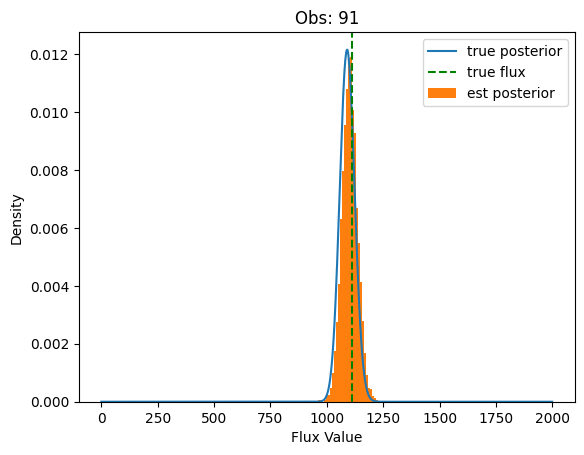

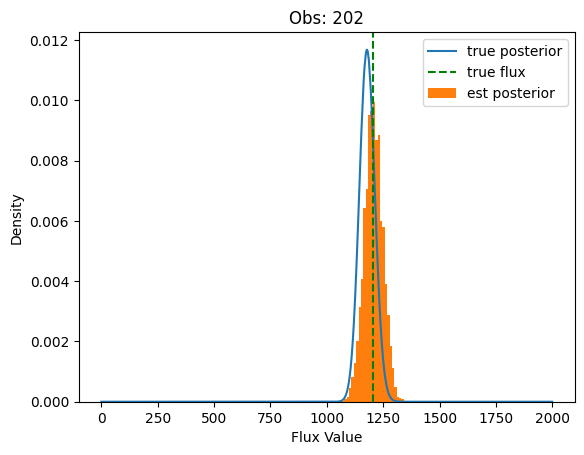

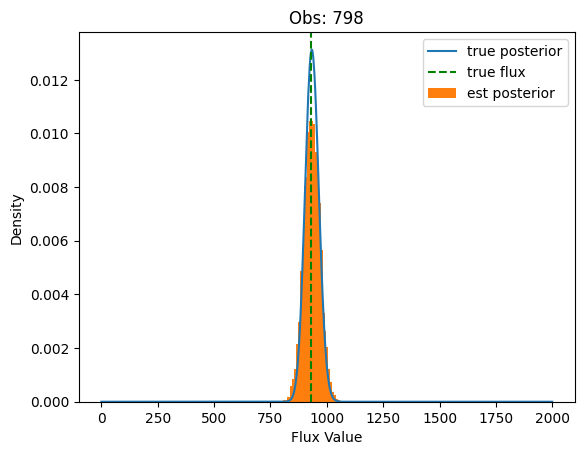

In [35]:
x = torch.linspace(0, 2000, 5000)
obs_index = [91, 202, 798]
for i in obs_index:
    plt.plot(x, true_post_dist.log_prob(x.view(-1, 1))[:, i].exp().cpu(), label="true posterior")
    plt.axvline(x=val_true_fluxes[i].item(), color="green", linestyle="dashed", label="true flux")
    plt.hist(val_est_fluxes[:, i, 0].cpu(), density=True, bins=30, label="est posterior")
    plt.legend()
    plt.xlabel("Flux Value")
    plt.ylabel("Density")
    plt.title(f"Obs: {i}")
    plt.show()

In [ ]:
with torch.no_grad():
    nll = my_net.nll(image=input_image, true_fluxes=encode_flux(val_true_fluxes.to(device=device)))

In [41]:
nll.median(), nll.mean()

(tensor(-2.7870, device='cuda:5'), tensor(-2.5156, device='cuda:5'))

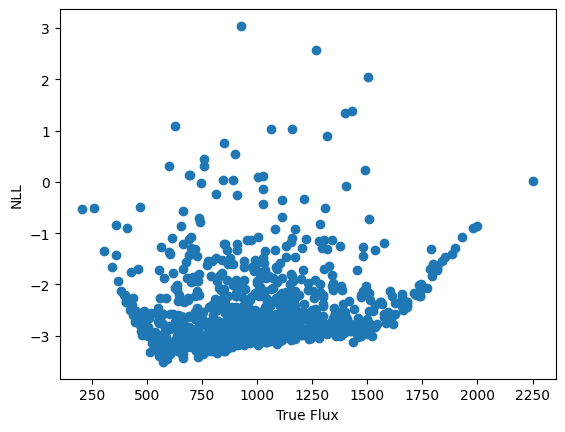

In [49]:
plt.scatter(val_true_fluxes.flatten().cpu(), nll.cpu())
# plt.yscale("log")
plt.ylabel("NLL")
plt.xlabel("True Flux")
plt.show()

In [38]:
ori_nll = nll + 1 * np.log(1 / max_flux_boundary)

In [43]:
ori_nll.median(), ori_nll.mean()

(tensor(-10.3879, device='cuda:5'), tensor(-10.1165, device='cuda:5'))

In [44]:
ori_nll.quantile(q=torch.tensor([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99], device=device))

tensor([-10.9472, -10.7262, -10.5995, -10.3874,  -9.8846,  -9.1377,  -7.0554],
       device='cuda:5')

In [40]:
(ori_nll / np.log(2)).median()

tensor(-14.9866, device='cuda:5')